[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1IZ1iVzRthkfCi2KC5B70Y-l4ipO0NmiT?usp=sharing)

Submitted By: Chiara Vega

# PROBLEM SET 2 (50 points)


![](images/fred-retail.png)

You are tasked to implement the development of a time series anomaly detection model based on [this](https://fred.stlouisfed.org/series/RSXFSN) dataset.  As you can see in the plot you should be able to identify at minimum 3 anomalies represented by the shaded regions (2001, 2008 depression and COVID recession).

Downloads the dataset as csv and ensure your code is able to read it without any user intervention other than executing the whole notebook.



### PS2.A (15 points)

Construct an LSTM autoencoder model and explain why LSTM autoencoders versus MLP / Dense autoencoders are suitable for this task. Make sure to clearly write how the LSTM autoencoder will perform anomaly detection.


In [ ]:
# Write here the LSTM autoencoder model code

**LSTM vs MLP and Dense Autoencoders**

In this section, a Long Short-Term Memory (LSTM) autoencoder model is constructed for time series anomaly detection in a dataset, contained within `RSXFSN.csv`, representing retail sales over the years from 1992 to 2023. As opposed to MLP (Multi-Layer Perceptron) or Dense autoencoders, LSTM autoencoders are more suitable because LSTMs have "cell states" that can, via the gates, recall or forget information that can be retained for the long-term. With the cell states, LSTMs can efficiently learn and capture temporal long-term dependencies and complex patterns present in sequential data, while, in a way, the LSTM's hidden state represents short-term (this will be discussed further in the last section).

Now, let's begin by working out how the LSTM autoencoder model will be built and will perform anomaly detection.

**Data Preprocessing**

Data preprocessing is done by reading the data from the supplied URL and extracting the relevant columns. Then, for evaluation, it is divided into a train set (80% of the data) and a test set (20% of the data). The data is standardized using the Scikit-learn `StandardScaler`, which scales the retail sales numbers.

The `get_timeseries` function is then defined to generate time series data for training and testing. This function creates sequences of a given length (`sequence_length`) and the labels that correspond to each sequence's subsequent data point.

**LSTM Autoencoder Model**

The latent space architecture of the LSTM autoencoder model is defined to learn a compressed representation of the input time series data. There are two LSTM layers in it, each with either 64 or 32 units, respectively. With this setup, the input sequence is successfully encoded into a fixed-size representation.

The `RepeatVector` layer replicates the latent representation to match the length of the original input sequence to aid with sequence reconstruction. The original sequence is recreated with two extra LSTM layers, each with 32 and 64 units, respectively. The `TimeDistributed` layer wraps a `Dense` layer for a dense transformation to be applied across all time steps in the sequence.

To prepare for training the model, the the mean squared error (MSE) loss function and Adam optimizer with a learning rate of 0.001 are utilized. The difference between the input sequence and its corresponding reconstruction is calculated using the MSE loss. The LSTM autoencoder learns to recognize the underlying patterns in the retail sales time series by minimizing this MSE loss. This is the setup that will be used to train the LSTM autoencoder in the following section.

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Read the data
df = pd.read_csv("https://raw.githubusercontent.com/GHcpv24/CS634-Data-Mining/Exams/RSXFSN.csv")
df.head()

,DATE,RSXFSN
0,1992-01-01,130683.0
1,1992-02-01,131244.0
2,1992-03-01,142488.0
3,1992-04-01,147175.0
4,1992-05-01,152420.0


In [ ]:
# Extract the columns of interest
dates = df['DATE']
df = df[['RSXFSN']]

In [ ]:
# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_set, test_set = df.iloc[:train_size], df.iloc[train_size:]

# Standardize by scaling
scaler = StandardScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.transform(test_set)

sequence_length = 10

def get_timeseries(x, sequence_length=1):
    x_sequence = np.array([x[i:i+sequence_length] for i in range(len(x)-sequence_length)])
    y_sequence = np.array([x[i+sequence_length] for i in range(len(x)-sequence_length)])
    return x_sequence, y_sequence

# Create time series data for training and testing
X_train, y_train = get_timeseries(train_set, sequence_length)
X_test, y_test = get_timeseries(test_set, sequence_length)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (292, 10, 1)
Test set shape: (66, 10, 1)


In [ ]:
# Build LSTM Autoencoder model
num_features = 1
lr = 0.001

input_shape = (sequence_length, num_features)
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(RepeatVector(sequence_length))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(num_features)))

model.compile(optimizer=Adam(lr), loss='mse')

### PS2.B (15 points)

Train the LSTM autoencoder to a suitable metric (loss function) that will be able to reveal anomalies. Ensure you comment your code fully and clearly the training and test datasets.


In [ ]:
# Write here the LSTM autoencoder training code

Now, the process for training the LSTM autoencoder model can begin in this section. As a reminder, the trained for anomaly detection using the provided training dataset. As stated in the previous section, an LSTM autoencoder is useful for jobs involving sequential data, such as time series - its goal is to capture temporal long-term dependencies in the data.

The model is initially trained using the `model.fit()` function on the training set of data. A whole pass across the training dataset is represented by each of the 25 epochs that make up the training process. The model adjusts its weights after processing each batch of 32 samples when using a batch size of 32 for training. A validation split of 10% is also used to monitor the training process. The validation set allows for evaluation of the model's performance on unseen data and detect overfitting. Insights can be gained by observing training and validation losses over each epoch - into how well the model is picking up on the underlying patterns in the data.

Following the model trainig, the reconstruction errors are computed for detecting anomalies in the test dataset. The Mean Squared Error (MSE) between the predicted output and the actual test data is determined. The model predicts the output for the test data (`X_test`). The difference between the original data and its autoencoder-reconstructed version is measured by this MSE. Anomalies may be indicated by data points with high MSE values that significantly deviate from the learned patterns.

The mean and standard deviation of the MSE values are computed to establish a threshold for anomaly detection - a threshold equaling the sum of the mean MSE and the standard deviation multiplied by 2.5. It is set so that any MSE value above this threshold is regarded as an anomaly.

In this particular case, the number of anomalies detected by the model is: 5 anomalies. Keep this in mind as these 5 anomalies will appear in the next section to follow. Having the information of anomalies printed helps in understanding the extent of abnormal data points in the test data. The LSTM autoencoder proves effective in detecting anomalies in the time series data, enabling for obtaining insights into unusual events or behaviors that deviate from the learned normal patterns.

In [ ]:
# Train the LSTM autoencoder model
epochs = 25
batch_size = 32

history = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1, shuffle=False)

Epoch 1/25
9/9 [==============================] - 13s 144ms/step - loss: 0.7745 - val_loss: 2.3917
Epoch 2/25
9/9 [==============================] - 1s 73ms/step - loss: 0.7505 - val_loss: 2.3702
Epoch 3/25
9/9 [==============================] - 1s 72ms/step - loss: 0.7252 - val_loss: 2.3378
Epoch 4/25
9/9 [==============================] - 1s 77ms/step - loss: 0.6675 - val_loss: 2.2767
Epoch 5/25
9/9 [==============================] - 1s 71ms/step - loss: 0.5029 - val_loss: 2.1338
Epoch 6/25
9/9 [==============================] - 1s 78ms/step - loss: 30.8977 - val_loss: 1.7373
Epoch 7/25
9/9 [==============================] - 1s 78ms/step - loss: 0.3806 - val_loss: 4.2499
Epoch 8/25
9/9 [==============================] - 1s 77ms/step - loss: 1.1374 - val_loss: 11.4650
Epoch 9/25
9/9 [==============================] - 1s 76ms/step - loss: 0.5105 - val_loss: 1.6541
Epoch 10/25
9/9 [==============================] - 1s 70ms/step - loss: 0.5425 - val_loss: 1.8806
Epoch 11/25
9/9 [========

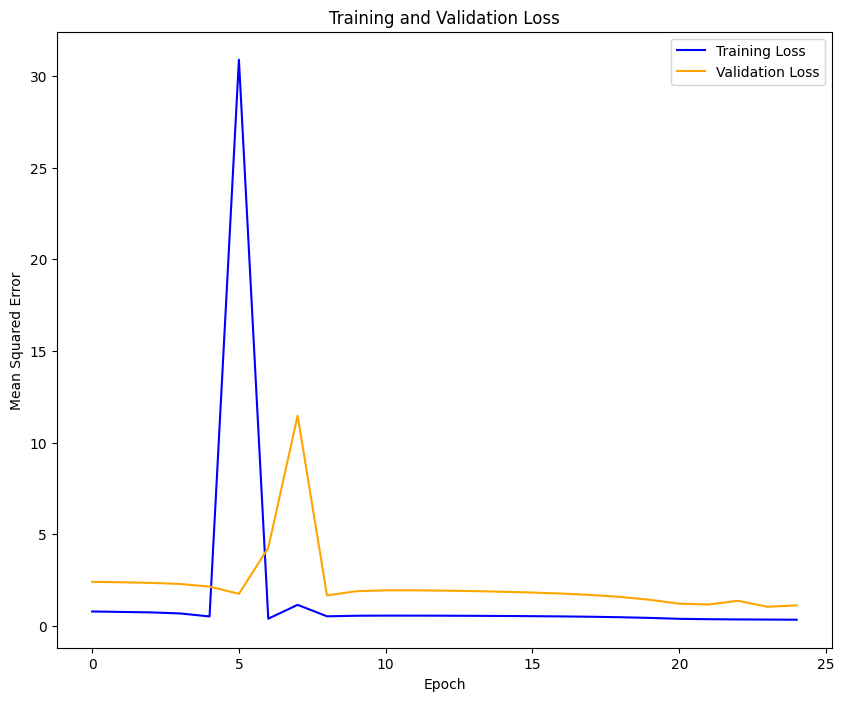

In [ ]:
# Plot the training and validation loss history
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Process for detecting anomalies
# Calculate reconstruction errors (Mean Squared Error) for each sample in the test set
# Calculate mean and standard deviation of the reconstruction errors
# Set a suitable threshold for anomaly detection (e.g., using a multiple of standard deviation)
# Detect anomalies by comparing the reconstruction errors with the threshold

y_pred = model.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)
mean_mse = np.mean(mse)
std_dev_mse = np.std(mse)

threshold = mean_mse + 2.5 * std_dev_mse

anomalies = mse > threshold

# Print the number of anomalies detected
print("Number of anomalies detected:", np.sum(anomalies))

3/3 [==============================] - 0s 8ms/step
Number of anomalies detected: 5


### PS2.C (10 points)

Plot the retail sales over time but with the anomalies highlighted with red color.

In [ ]:
# Plot of time series data here

Recall that in the previous section, the model detected 5 anomalies. Therefore, you will find 5 anomalies marked on the below plot as red dots, though the bottom two dots may be hard to distinguish from the other due to being almost completely overlapping.

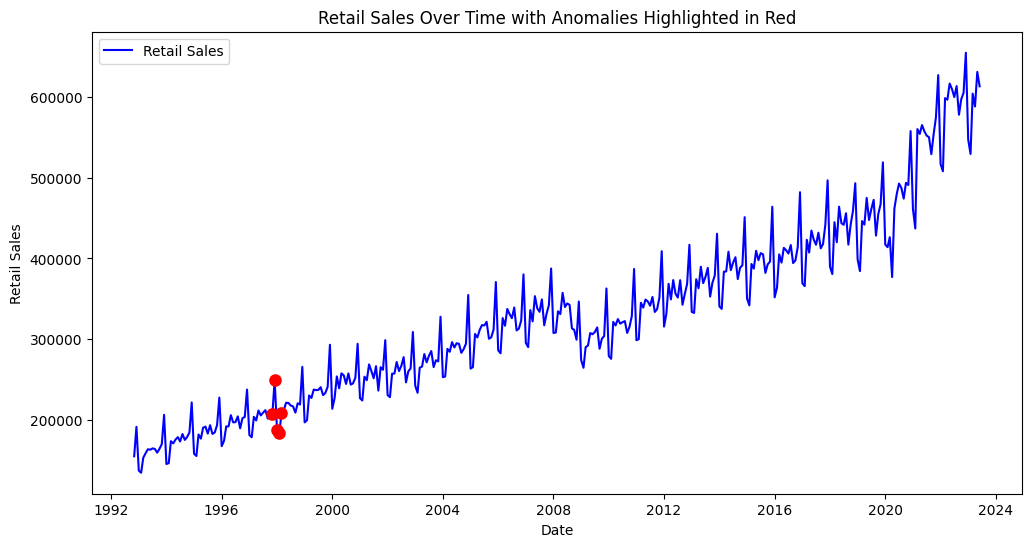

In [ ]:
# Convert 'DATE' index to datetime
df.index = pd.to_datetime(dates)

# Plot the retail sales over time with the anomalies marked as red points
plt.figure(figsize=(12, 6))
plt.plot(df.index[sequence_length:], df['RSXFSN'][sequence_length:], label='Retail Sales', color='blue')

for i in range(sequence_length, len(anomalies) + sequence_length):
    if anomalies[i - sequence_length]:
        plt.scatter(df.index[i], df['RSXFSN'][i], c='red', marker='o', s=50, linewidths=2, edgecolors='red', zorder=10)

plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.title('Retail Sales Over Time with Anomalies Highlighted in Red')
plt.legend()
plt.show()

## PS2.D (10 points)

Explain what the hidden state of the LSTM represent represents.  

Explain in this cell  ...

To reiterate what I stated in the first section, LSTMs have "cell states" that can, via the gates, recall or forget information that can be retained for the long-term. Now, an LSTM's hidden state, which also captures important patterns and dependencies, can be thought of representing capturing the short-term - as the hidden state represents the extracted and summarized information from the input sequence. The hidden state acts as an internal tensor utilized in monitoring the LSTM's memory over time - being updated, based on the input and previous hidden state, at each time step and then transmitted to the subsequent time step as the new hidden state. Simply put, the relevant data from the cell state must be encoded by the hidden state before being transmitted to the subsequent time step. In essence, in an LSTM autoencoder, the hidden state is crucial for compressing and reconstructing the input data - by identifying abnormalities from the learned patterns, the hidden state makes effective anomaly detection possible.